In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from time import perf_counter
from functools import partial
import random
from numba import jit
import scipy as sp

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [44]:
s = np.load("new_s.npy")
h = np.load("b.npy")
J = np.load("w.npy")
b = np.load("b.npy")
w = np.load("w.npy")

In [45]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -(np.log(10000) / (half_dim-1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=40, n_class=2, embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(n_class+1, embed_dim)
        time_embed_dim = 128
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)
        self.enc1 = nn.Linear(input_dim + time_embed_dim + embed_dim, 128)
        self.enc2 = nn.Linear(128, 256)
        self.enc3 = nn.Linear(256, 512)
        self.dec1 = nn.Linear(512, 512)
        self.dec2 = nn.Linear(512, 512)
        self.dec3 = nn.Linear(512, 256)
        self.dec4 = nn.Linear(256, 128)
        self.out = nn.Linear(128, input_dim)
        self.act = nn.GELU()
    def forward(self, x, t, y):
        t_embed = self.time_embed(t).to(x.dtype)
        y_embed = self.embedding(y).to(x.dtype)
        h = torch.cat([x, t_embed, y_embed], dim=1)
        h1 = self.act(self.enc1(h))
        h2 = self.act(self.enc2(h1))
        h3 = self.act(self.enc3(h2))
        d1 = self.act(self.dec1(h3))
        d2 = self.act(self.dec2(d1) + d1)
        d3 = self.act(self.dec3(d2) + h2)
        d4 = self.act(self.dec4(d3) + h1)
        return self.out(d4)

# ------------------------------
# 3. DDPM 정의
# ------------------------------
class DDPM(nn.Module):
    def __init__(self, model, beta_start=0.001, beta_end=0.02, n_T=1000, device='cuda'):
        super().__init__()
        self.model = model
        self.n_T = n_T
        self.device = device

        betas = torch.linspace(beta_start, beta_end, n_T).to(device)
        alphas = 1 - betas
        alphabar = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphabar", alphabar)
        self.register_buffer("sqrtab", torch.sqrt(alphabar))
        self.register_buffer("sqrtmab", torch.sqrt(1 - alphabar))
        self.register_buffer("oneover_sqrta", 1 / torch.sqrt(alphas))
        self.register_buffer("bt_over_sqrtmab", betas / torch.sqrt(1 - alphabar))
        self.register_buffer("sqrt_beta_t", torch.sqrt(betas))

    def forward(self, x, y):
        B = x.shape[0]
        t = torch.randint(1, self.n_T+1, (B,), device=x.device).float()
        sqrtab_t = self.sqrtab[t.long()-1].view(B, 1)
        sqrtmab_t = self.sqrtmab[t.long()-1].view(B, 1)
        eps = torch.randn_like(x)
        x_t = sqrtab_t * x + sqrtmab_t * eps
        eps_pred = self.model(x_t, t, y)
        return F.mse_loss(eps_pred, eps)


# ------------------------------
# 5. Training Loop & 샘플링
# ------------------------------
# 모델 인스턴스 생성 (구조 동일해야 함!)
n_class = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionMLP(n_class=n_class).to(device)

# 저장된 파라미터 로드
epoch = 16000
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.eval() 
ddpm = DDPM(model, device=device).to(device)

n_sample_per_batch = 500
n_batches = 100  # 1000 * 100 = 100,000
N = 40
guidance_scale = 1.0
for y_value, label in zip([0, 1], ['freq', 'rare']):
    for batch_idx in range(n_batches):
        with torch.no_grad():  # 추가!
            x = torch.randn(n_sample_per_batch, N).to(device)

            for t in reversed(range(1, ddpm.n_T + 1)):
                t_batch = torch.full((n_sample_per_batch,), t, device=device).float()
                y_cond = torch.full((n_sample_per_batch,), y_value, device=device, dtype=torch.long)
                y_null = torch.ones_like(y_cond) * n_class

                eps_cond = model(x, t_batch, y_cond)
                eps_null = model(x, t_batch, y_null)
                eps = eps_null + guidance_scale * (eps_cond - eps_null)

                mu = ddpm.oneover_sqrta[t-1] * (x - ddpm.bt_over_sqrtmab[t-1] * eps)
                sigma = ddpm.sqrt_beta_t[t-1]
                z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
                x = mu + sigma * z

            # numpy 저장
            x_numpy = x.cpu().numpy()
            os.makedirs(f"{label}_{epoch}", exist_ok=True)
            np.save(f"{label}_{epoch}/{label}_batch_{batch_idx:03d}.npy", x_numpy)

        torch.cuda.empty_cache()  # 추가: 메모리 해제!
        print(f"✅ Saved {label}_{batch_idx:03d}.npy ({n_sample_per_batch} samples)")



/tmp/ipykernel_127295/174701596.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))


✅ Saved freq_000.npy (500 samples)
✅ Saved freq_001.npy (500 samples)
✅ Saved freq_002.npy (500 samples)
✅ Saved freq_003.npy (500 samples)
✅ Saved freq_004.npy (500 samples)
✅ Saved freq_005.npy (500 samples)
✅ Saved freq_006.npy (500 samples)
✅ Saved freq_007.npy (500 samples)
✅ Saved freq_008.npy (500 samples)
✅ Saved freq_009.npy (500 samples)
✅ Saved freq_010.npy (500 samples)
✅ Saved freq_011.npy (500 samples)
✅ Saved freq_012.npy (500 samples)
✅ Saved freq_013.npy (500 samples)
✅ Saved freq_014.npy (500 samples)
✅ Saved freq_015.npy (500 samples)
✅ Saved freq_016.npy (500 samples)
✅ Saved freq_017.npy (500 samples)
✅ Saved freq_018.npy (500 samples)
✅ Saved freq_019.npy (500 samples)
✅ Saved freq_020.npy (500 samples)
✅ Saved freq_021.npy (500 samples)
✅ Saved freq_022.npy (500 samples)
✅ Saved freq_023.npy (500 samples)
✅ Saved freq_024.npy (500 samples)
✅ Saved freq_025.npy (500 samples)
✅ Saved freq_026.npy (500 samples)
✅ Saved freq_027.npy (500 samples)
✅ Saved freq_028.npy

In [46]:
import numpy as np
import os
epoch = 16000
def load_samples(label: str, total_samples: int, batch_size: int = 500, base_dir: str = '.'):
    """
    label: 'freq', 'rare', 'null'
    total_samples: 불러올 총 샘플 수
    batch_size: 한 파일에 저장된 샘플 수
    base_dir: npy 파일이 저장된 디렉토리
    """
    n_batches = total_samples // batch_size
    all_samples = []

    for i in range(n_batches):
        file_path = os.path.join(base_dir, f"{label}_{epoch}/{label}_batch_{i:03d}.npy")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"파일 없음: {file_path}")
        batch = np.load(file_path)
        all_samples.append(batch)

    samples = np.vstack(all_samples)
    print(f"[{label}] 총 {samples.shape[0]}개 로드 완료.")
    return samples

# 샘플 5000개 로드
x_freq_5k = load_samples("freq", total_samples=50000)
x_rare_5k = load_samples("rare", total_samples=50000)

x_freq_5k = np.vstack([x_freq_5k, s])
x_rare_5k = np.vstack([x_rare_5k, s])

s_ = np.vstack([x_freq_5k, x_rare_5k, s])

[freq] 총 50000개 로드 완료.
[rare] 총 50000개 로드 완료.


In [47]:
def energy_general_ising(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def metropolis_sample(L, b, w, beta=1.0, n_steps=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    seq = np.random.choice([-1, 1], size=L)
    local_field = b + np.dot(w, seq)

    for step in range(n_steps):
        i = np.random.randint(L)
        dE = 2 * seq[i] * local_field[i]

        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            seq[i] *= -1
            local_field += 2 * w[:, i] * seq[i]

    return seq

def sample_general_ising(L, N, b, w, beta=1.0, n_steps=1000, n_jobs=10):
    from joblib import parallel_backend

    seeds = np.random.randint(0, 1e6, size=N)

    with parallel_backend('loky'):
        samples = Parallel(n_jobs=n_jobs)(
            delayed(metropolis_sample)(L, b, w, beta, n_steps, int(seeds[i]))
            for i in tqdm(range(N), desc="Sampling Ising states", unit="sample")
        )

    return np.array(samples)

def plot_energy_histogram_general(samples, b, w, color='cornflowerblue', bins = 30):
    energies = np.array([energy_general_ising(s, b, w) for s in samples])
    plt.hist(energies, bins=bins, density=True, color=color, edgecolor='black', alpha=0.6)
    plt.title(f"Ising Model Energy Histogram L = {L}")
    plt.xlabel("Energy")
    plt.ylabel("A.U.")
    plt.grid(True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_energy(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def estimate_f_epsilon(samples, b, w, epsilon):
    energies = np.array([compute_energy(s, b, w) for s in samples])
    ps = np.exp(-energies)
    ps_epsilon = ps ** (-1 + epsilon)
    weights = ps_epsilon / np.sum(ps_epsilon)
    return weights


def update_parameters(samples, b, w, epsilon, lr):
    n = samples.shape[1]
    weights = estimate_f_epsilon(samples, b, w, epsilon)

    mean_sigma = np.zeros(n)
    for s, wgt in zip(samples, weights):
        mean_sigma += wgt * s
    #mean_sigma = np.average(samples, axis=0, weights=weights)  # ⟨σ_i⟩_{f_ε}
    mean_sigma_sigma = np.zeros((n, n))
    for s, wgt in zip(samples, weights):
        #mean_sigma_sigma += wgt * np.einsum("i,j->ij", s, s)
        mean_sigma_sigma += wgt * np.outer(s, s)
    np.fill_diagonal(mean_sigma_sigma, 0)
    b_model = epsilon * b
    w_model = epsilon * w

    #print(np.linalg.norm(mean_sigma - b_model))
    
    # Gradient update
    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)
    
    return b_new, w_new

# === Example Usage ===
def train_erasure_machine(samples, n, epsilon=0.05, lr=0.1, epochs=100):
    b_temp = np.random.randn(n) * 0.01
    w_temp = np.random.randn(n, n) * 0.01
    w_temp = (w_temp + w_temp.T) / 2  # Make symmetric
    np.fill_diagonal(w_temp, 0)

    for epoch in range(epochs):
        b_temp, w_temp = update_parameters(samples, b_temp, w_temp, epsilon, lr)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: b norm = {np.linalg.norm(b_temp):.4f}, w norm = {np.linalg.norm(w_temp):.4f}")
    return b_temp, w_temp

In [48]:
L = 40
def mse(w, w_e, b, b_e) :
    LL = L + L*(L-1)/2
    b_error = np.sum((b_e - b)**2)/LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_e - w) * mask
    w_error = np.sum(w_diff**2)/LL
    return (b_error + w_error)


In [49]:
import torch
import numpy as np

def compute_energy_torch(samples, b, w):
    # energy = -b·σ - sum_{i<j} w_ij σ_i σ_j
    field_term = -torch.matmul(samples, b)
    interaction_term = -0.5 * torch.sum(samples @ w * samples, dim=1)
    return field_term + interaction_term

def estimate_f_epsilon_torch(samples, b, w, epsilon):
    with torch.no_grad():
        energies = compute_energy_torch(samples, b, w)
        ps = torch.exp(-energies)
        ps_epsilon = ps ** (-1 + epsilon)
        weights = ps_epsilon / ps_epsilon.sum()
    return weights

def update_parameters_torch(samples, b, w, epsilon, lr):
    weights = estimate_f_epsilon_torch(samples, b, w, epsilon)

    mean_sigma = torch.sum(weights[:, None] * samples, dim=0)

    outer = samples.unsqueeze(2) * samples.unsqueeze(1)  # shape: (N, L, L)
    weighted_outer = weights[:, None, None] * outer
    mean_sigma_sigma = torch.sum(weighted_outer, dim=0)
    mean_sigma_sigma.fill_diagonal_(0.0)

    b_model = epsilon * b
    w_model = epsilon * w

    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)

    return b_new, w_new

def train_erasure_machine_torch(samples_np, n, epsilon=0.05, lr=0.1, epochs=100, use_cuda=True):
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    samples = torch.tensor(samples_np, dtype=torch.float32, device=device)

    b = torch.randn(n, device=device) * 0.01
    w = torch.randn(n, n, device=device) * 0.01
    w = (w + w.T) / 2
    w.fill_diagonal_(0.0)

    for epoch in range(epochs):
        b, w = update_parameters_torch(samples, b, w, epsilon, lr)
        if epoch % 10 == 0:
            print(f"[GPU] Epoch {epoch}: b norm = {b.norm():.4f}, w norm = {w.norm():.4f}")
    return b.cpu().numpy(), w.cpu().numpy()


In [50]:
# new_s = np.load("ising_samples_diff.npy")
# new_h = np.load("ising_h_diff.npy")
# new_J = np.load("ising_J_diff.npy")

# b_s, w_s = train_erasure_machine(new_s, N, epsilon=0.84, lr=0.1, epochs=200)

# mse_new = mse(new_J, w_s, new_h, b_s)
# print(f"New MSE: {mse_new:.4f}")

In [63]:
def run_erasure_machine(samples, epsilon=0.7, lr=0.1, epochs=150):
    n = samples.shape[1]
    b_learned, w_learned = train_erasure_machine_torch(samples, n, epsilon=epsilon, lr=lr, epochs=epochs)
    return b_learned, w_learned

# Erasure Machine 학습
b_freq, w_freq = run_erasure_machine(x_freq_5k)
b_rare, w_rare = run_erasure_machine(x_rare_5k)
b_learned_s, w_learned_s = run_erasure_machine(s)

[GPU] Epoch 0: b norm = 0.3703, w norm = 1.3129
[GPU] Epoch 10: b norm = 1.5396, w norm = 3.4629
[GPU] Epoch 20: b norm = 1.9187, w norm = 3.8367
[GPU] Epoch 30: b norm = 2.0873, w norm = 3.9699
[GPU] Epoch 40: b norm = 2.1660, w norm = 4.0206
[GPU] Epoch 50: b norm = 2.2032, w norm = 4.0400
[GPU] Epoch 60: b norm = 2.2210, w norm = 4.0474
[GPU] Epoch 70: b norm = 2.2295, w norm = 4.0503
[GPU] Epoch 80: b norm = 2.2335, w norm = 4.0513
[GPU] Epoch 90: b norm = 2.2355, w norm = 4.0517
[GPU] Epoch 100: b norm = 2.2364, w norm = 4.0519
[GPU] Epoch 110: b norm = 2.2368, w norm = 4.0519
[GPU] Epoch 120: b norm = 2.2371, w norm = 4.0519
[GPU] Epoch 130: b norm = 2.2372, w norm = 4.0520
[GPU] Epoch 140: b norm = 2.2372, w norm = 4.0520
[GPU] Epoch 0: b norm = 0.2247, w norm = 0.4544
[GPU] Epoch 10: b norm = 1.2098, w norm = 1.8589
[GPU] Epoch 20: b norm = 1.5619, w norm = 2.2108
[GPU] Epoch 30: b norm = 1.7079, w norm = 2.3156
[GPU] Epoch 40: b norm = 1.7724, w norm = 2.3476
[GPU] Epoch 50: b

In [64]:
x = np.concatenate([b, w[np.triu_indices_from(w, k=1)]])
y = np.concatenate([b_freq, w_freq[np.triu_indices_from(w, k=1)]])
y2 = np.concatenate([b_rare, w_rare[np.triu_indices_from(w, k=1)]])
y_s = np.concatenate([b_learned_s, w_learned_s[np.triu_indices_from(w, k=1)]])

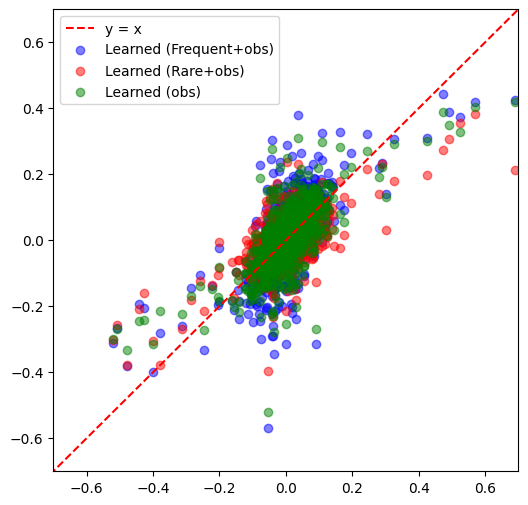

In [65]:
plt.figure(figsize=(6, 6))
plt.plot([-1, 1], [-1, 1], 'r--', label='y = x')
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.scatter(x, y, label='Learned (Frequent+obs)', alpha=0.5, color='blue')
plt.scatter(x, y2, label='Learned (Rare+obs)', alpha=0.5, color='red')
plt.scatter(x, y_s, label='Learned (obs)', alpha=0.5, color='green')
plt.legend()
plt.show()

In [62]:
mse_freq = mse(w, w_freq, b, b_freq)
mse_rare = mse(w, w_rare, b, b_rare)
mse_s = mse(w, w_learned_s, b, b_learned_s)
print(f"MSE (Frequent): {mse_freq:.4f}")
print(f"MSE (Rare): {mse_rare:.4f}")
print(f"MSE (Learned All): {mse_s:.4f}")

MSE (Frequent): 0.0063
MSE (Rare): 0.0052
MSE (Learned All): 0.0052


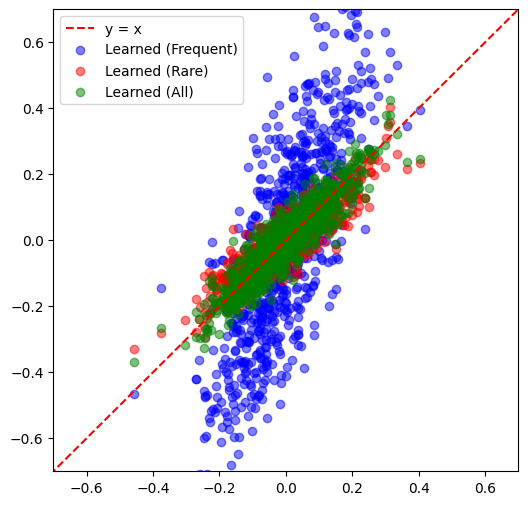

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot([-1, 1], [-1, 1], 'r--', label='y = x')
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.scatter(x, y, label='Learned (Frequent)', alpha=0.5, color='blue')
plt.scatter(x, y2, label='Learned (Rare)', alpha=0.5, color='red')
plt.scatter(x, y_s, label='Learned (All)', alpha=0.5, color='green')
plt.legend()
plt.show()